In [82]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_static_short")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    if len(peaks) < 3:
        return 0.
    for i in range(2, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)

    print(periods)
    return np.mean(periods)

def plotspectrum(data, fmax=1., filename=None):

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)]
        ps_plot[0] = 0.

        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        plt.plot(fr, ps_plot)

    plt.xlim(-0.01,fmax)
    plt.ylim(0,1.1*np.amax(ps_plot))
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_static_short


In [2]:
y0lim = [0, 0.6]

def plot_control(data, dur, dt, wi, filename=None, title=None):
    fig, ax = plt.subplots(2,3, figsize=(24,10), sharex="col", sharey="row", gridspec_kw={'width_ratios': [2, 2, 1]})
    time_array = np.arange(0, dur+dt, dt)

    cmax = max( np.amax(np.abs(data["control"][0])), np.amax(np.abs(data["control"][1])) )
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0, n].plot(time_array, data["state"][wi][n,0,:], color="red", label="E")
        ax[0, n].plot(time_array, data["state"][wi][n,1,:], color="blue", label="I")
        ax[1, n].plot(time_array, data["control"][wi][n,0,:], color="red", label="E")
        ax[1, n].plot(time_array, data["control"][wi][n,1,:], color="blue", label="I")

    i0, i1 = int(0.5* dur/dt), int(0.5* dur/dt) + 1000
    time_array = np.arange(i0*dt, i1*dt, dt)
    ax[0, 2].plot(time_array, data["state"][wi][0,0,i0:i1], color="red", label="N0")
    ax[0, 2].plot(time_array, data["state"][wi][1,0,i0:i1], color="red", linestyle=":", label="N1")
    ax[1, 2].plot(time_array, data["control"][wi][0,0,i0:i1], color="red")
    ax[1, 2].plot(time_array, data["control"][wi][1,0,i0:i1], color="red", linestyle=":")
    ax[1, 2].plot(time_array, data["control"][wi][0,1,i0:i1], color="blue")
    ax[1, 2].plot(time_array, data["control"][wi][1,1,i0:i1], color="blue", linestyle=":")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")
    ax[0,2].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(0, dur)
    ax[0,2].set_xlim(i0*dt, i1*dt)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[1,2].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0")
    ax[0,1].set_title("n=1")
    ax[0,2].set_title("n=0+1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

def plot_control1(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row")
    time_array = np.linspace(0,dur,s.shape[2])

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0, n].plot(time_array, s[n,0,:], color="red", label="E")
        ax[0, n].plot(time_array, s[n,1,:], color="blue", label="I")
        ax[1, n].plot(time_array, c[n,0,:], color="red", label="E")
        ax[1, n].plot(time_array, c[n,1,:], color="blue", label="I")


    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(0, dur)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0")
    ax[0,1].set_title("n=1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [3]:
p_names = ["D-exp", "D-osc", "U-exp", "U-osc", "Bi-exp", "Bi-osc"]
coords = [[1., 1.5], [1.613, 1.], [3., 1.], [2.2, 0.4], [2.2, 2.1], [2.4, 1.6]]

coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]

for i in range(len(p_names)):
    p = p_names[i]
    data["D-osc"]["coordinates"] = coords[i]

NameError: name 'data' is not defined

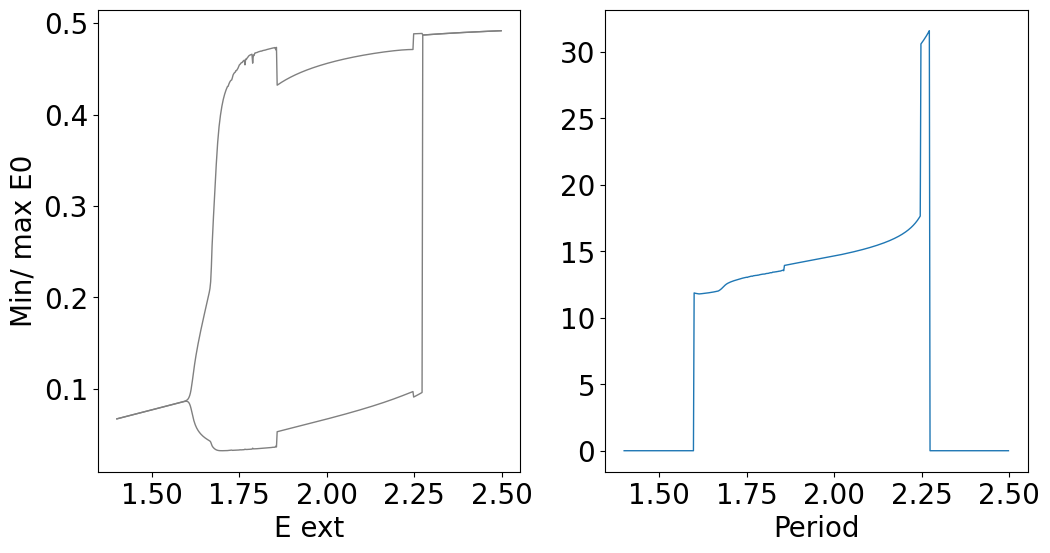

In [65]:
model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)

model.params['duration'] = 1e4
model.params.inh_ext_baseline = 1.
model.params.K_gl = coupling

excrange = np.arange(1.4, 2.5, 0.002)

periods = np.zeros((len(excrange)))
maxx = np.zeros((len(excrange)))
minn = np.zeros((len(excrange)))

for ei, exc in enumerate(excrange):
    model.params.exc_ext_baseline = exc
    model.run()

    #plt.plot(model.exc[0,-3000:])
    #plt.plot(model.exc[1,-3000:])
    #plt.show()

    per0 = get_period(-model.exc[0,10000:], dt)
    per1 = get_period(-model.exc[1,10000:], dt)
    periods[ei] = np.mean([per0, per1])
    maxx[ei] = np.amax(model.exc[0,10000:])
    minn[ei] = np.amin(model.exc[0,10000:])


fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(excrange, maxx, color=col)
ax[0].plot(excrange, minn, color="gray")
ax[1].plot(excrange, periods)

ax[0].set_xlabel("E ext")
ax[1].set_xlabel("E ext")

ax[0].set_ylabel("Min/ max E0")
ax[1].set_xlabel("Period")

plt.savefig(os.path.join(dir, "amp_period.png"))
plt.show()

D-osc


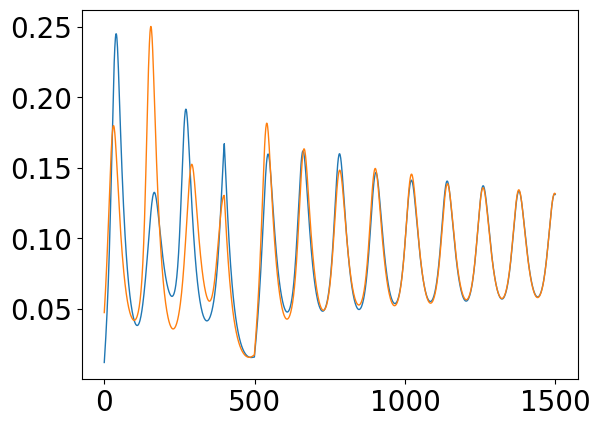

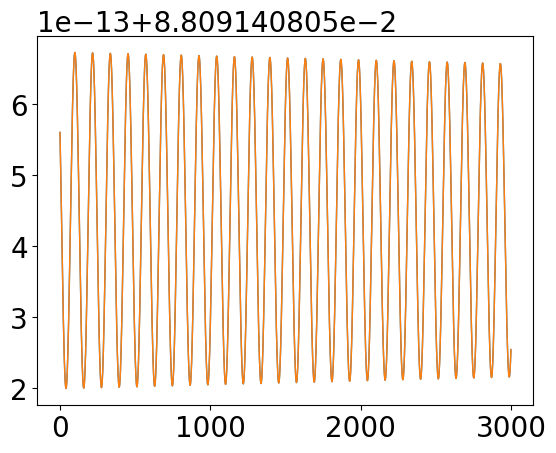

[11.8, 11.9, 11.8, 11.8, 11.9, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8]
[11.8, 11.9, 11.8, 11.8, 11.9, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.9, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8, 11.8]
11.81230769230769 11.81230769230769


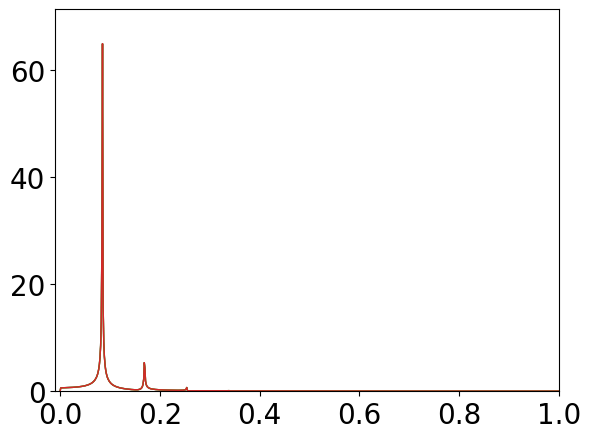

freq of max =  [0.08502126]
period of max =  [11.76176471]


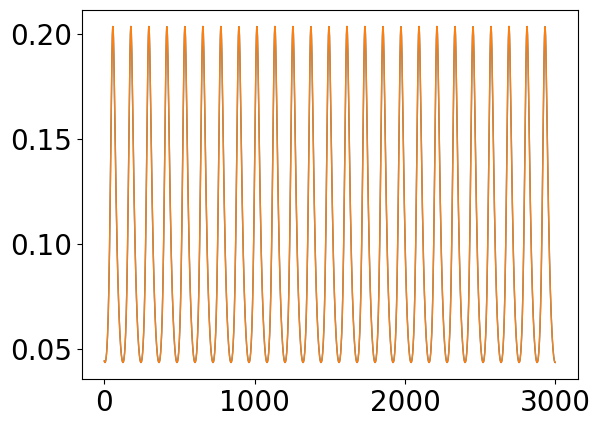

amplitude of oscillation =  0.16007613578119895


In [89]:
if True:
    data = dict()

    for i in range(len(p_names)):
        p = p_names[i]
        data[p] = dict()
        data[p]["coordinates"] = coords[i]
        data[p]["target_period"] = 20.
        data[p]["delay"] = 9.5

        if "Bi" in p:
            data[p]["control"] = [[None, None], [None, None]]
            data[p]["state"] = [[None, None], [None, None]]
            data[p]["init_state"] = [None, None]
            data[p]["weight"] = [[1., 1.], [1., 1.]]
            data[p]["dur/per"] = [[1000., 20], [1000., 20]]
        else:
            data[p]["control"] = [None, None]
            data[p]["state"] = [None, None]
            data[p]["init_state"] = None
            data[p]["weight"] = [5. * 1e-5, 5. * 1e-4]
            data[p]["dur/per"] = [340., 10]


duration = 1e5
dt = 0.1

data["U-osc"]["delay"] = 13.75
data["Bi-osc"]["delay"] = 9.5

test_input_plus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_plus[:,400:500] = 1.

test_input_minus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_minus[:,400:500] = -1.

for pi in range(len(p_names)):

    if "Bi" in p_names[pi]:
        continue

    if pi not in [1]: continue

    print(p_names[pi])

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    model.params["exc_ext"] = test_input_minus

    model.params.K_gl = coupling
    model.run()
    nmaxdelay = model.getMaxDelay()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"] = [einit, iinit]

    if "osc" in p_names[pi]:
        plt.plot(model.exc[0,0:1500])
        plt.plot(model.exc[1,0:1500])
        plt.show()
        plt.plot(model.exc[0,-3000:])
        plt.plot(model.exc[1,-3000:])
        plt.show()

        i0, i1 = 2000, 10000

        per0 = get_period(-model.exc[0,i0:i1], dt)
        per1 = get_period(-model.exc[1,i0:i1], dt)
        data[p_names[pi]]["target_period"] = np.mean([per0, per1])

        print(per0, per1)

        plotspectrum( [model.exc[0,i0:i1], model.exc[0,i0:i1], model.exc[0,i0:i1], model.exc[0,i0:i1]])

        model.params.exc_ext_baseline += 0.05
        model.run()
        #per0 = get_period(-model.exc[0,3000:], dt)
        #per1 = get_period(-model.exc[1,3000:], dt)
        #data[p_names[pi]]["target_period"] = np.mean([per0, per1])

        #print(per0, per1)

        plt.plot(model.exc[0,-3000:])
        plt.plot(model.exc[1,-3000:])
        plt.show()

        print("amplitude of oscillation = ", np.amax(model.exc[0,-3000:]) - np.amin(model.exc[0,-3000:]))

duration = 2000. 

for pi in range(len(p_names)):

    break

    if "Bi" not in p_names[pi]:
        continue

    print(p_names[pi])

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_plus
    model.params["inh_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,501:1500])
    plt.plot(model.exc[1,501:1500])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"][0] = [einit, iinit]

    model.params["exc_ext"] = test_input_minus
    model.params["inh_ext"] = test_input_minus
    model.run()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"][1] = [einit, iinit]

    if "osc" in p_names[pi]:
        plt.plot(model.exc[0,501:1500])
        plt.plot(model.exc[1,501:1500])
        plt.vlines([177, 348], 0, 0.5)
        plt.show()

        per0 = get_period(-model.exc[0,601:], dt)
        per1 = get_period(-model.exc[1,601:], dt)
        data[p_names[pi]]["target_period"] = np.mean([per0, per1])

        print(data[p]["target_period"])

In [145]:
controlmat = np.ones((N,2))

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

it = 50
maxstr = 5

pr = np.arange(0,1001,20)
testd = 1000.

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [15]:
def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [16]:
data["D-osc"]["weight"] = [1. * 1e-3, 1. * 1e-2]
data["D-osc"]["dur/per"] = [600., 20]

Point  D-osc
target period, max delay =  11.975865176640232 95
duration =  340.0
w2 =  5e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.0013663130107655181
Final cost : 0.0013663130107655181


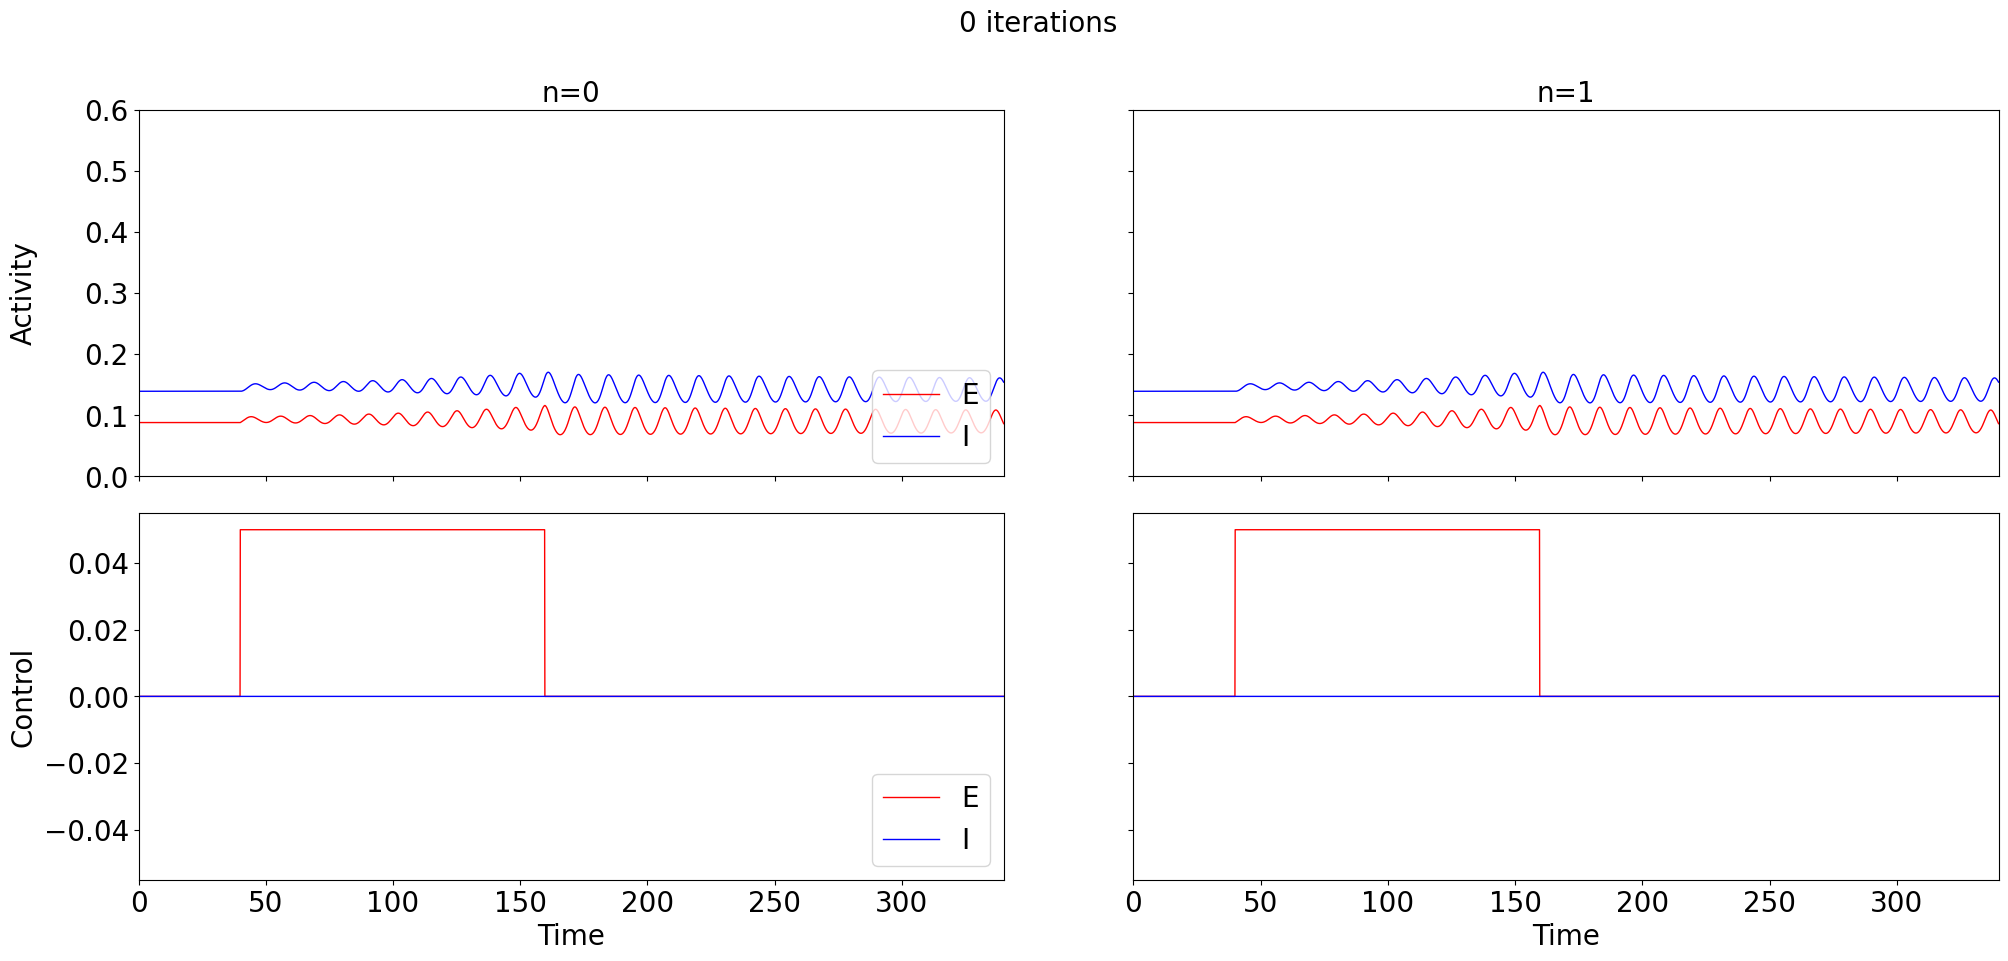

Compute control for a deterministic system
Cost in iteration 0: 0.0013663130107655181
Final cost : -0.0005200707876174329


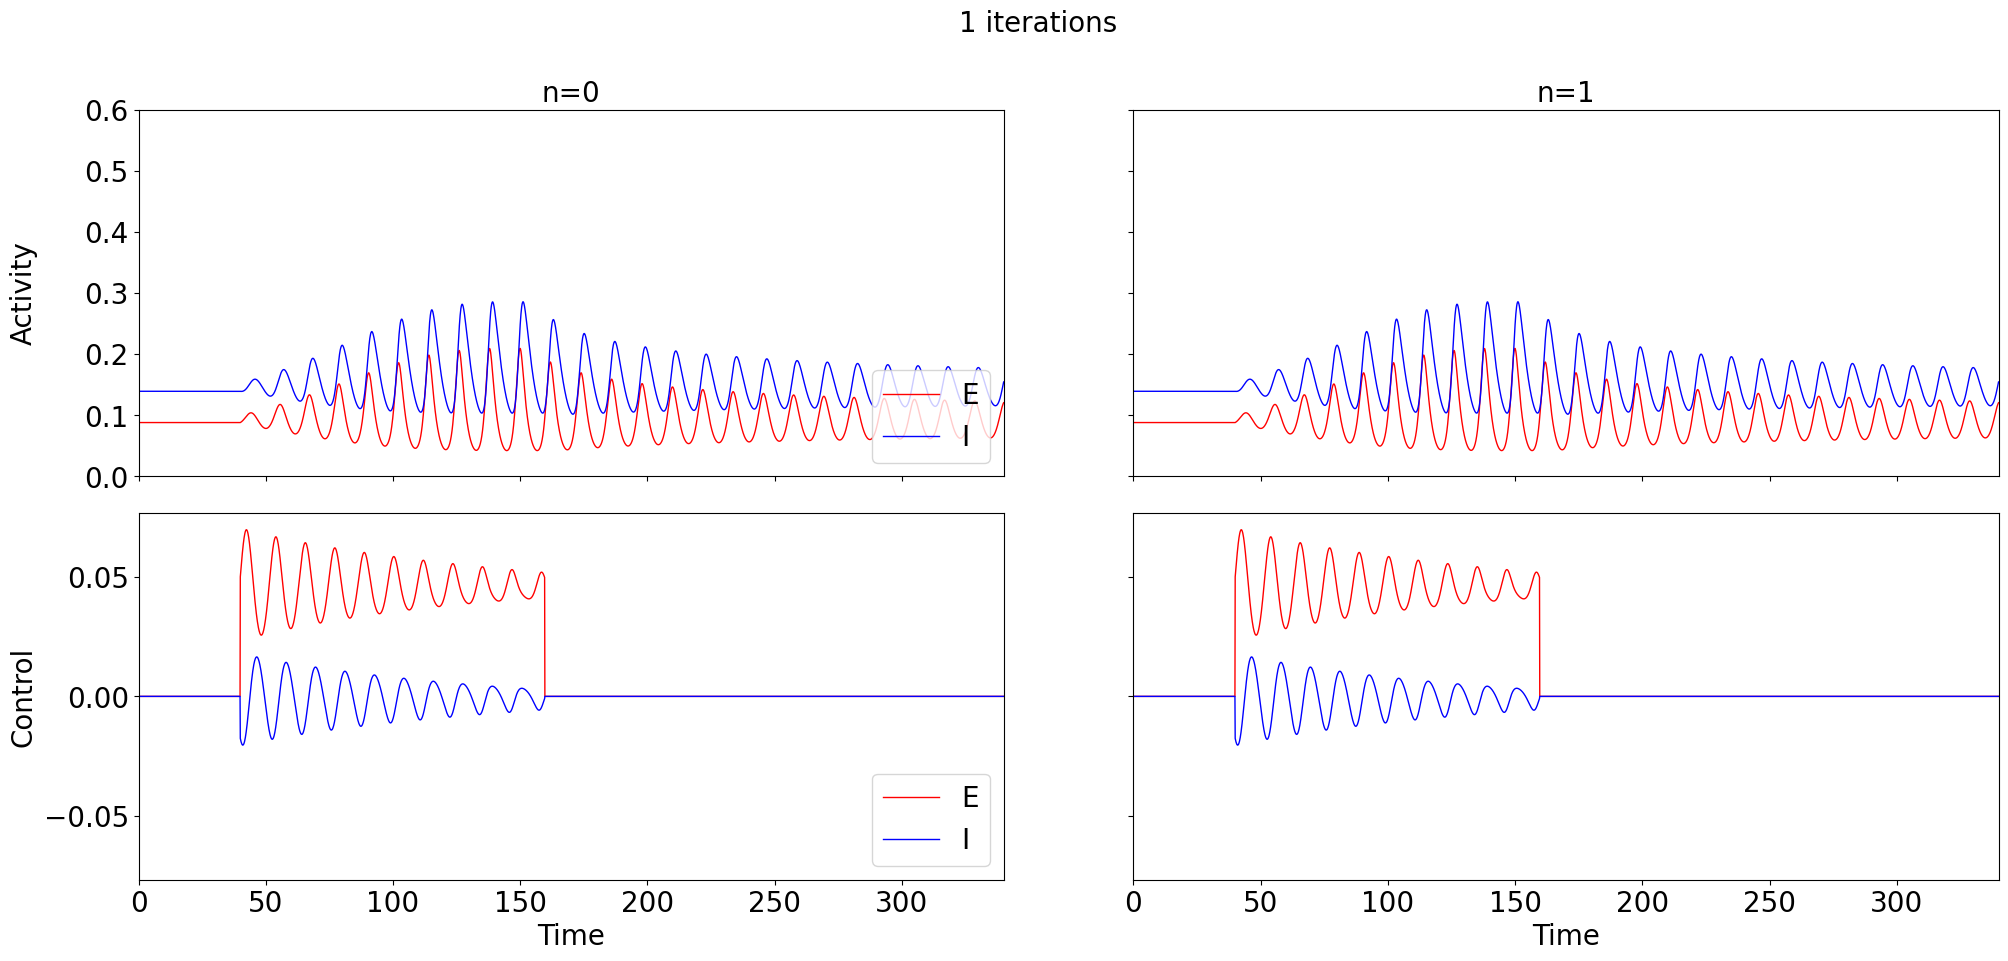

Compute control for a deterministic system
Cost in iteration 0: -0.0005200707876174329
Final cost : -0.002140995211021164
Compute control for a deterministic system
Cost in iteration 0: -0.002140995211021164
Final cost : -0.0021886415219285445


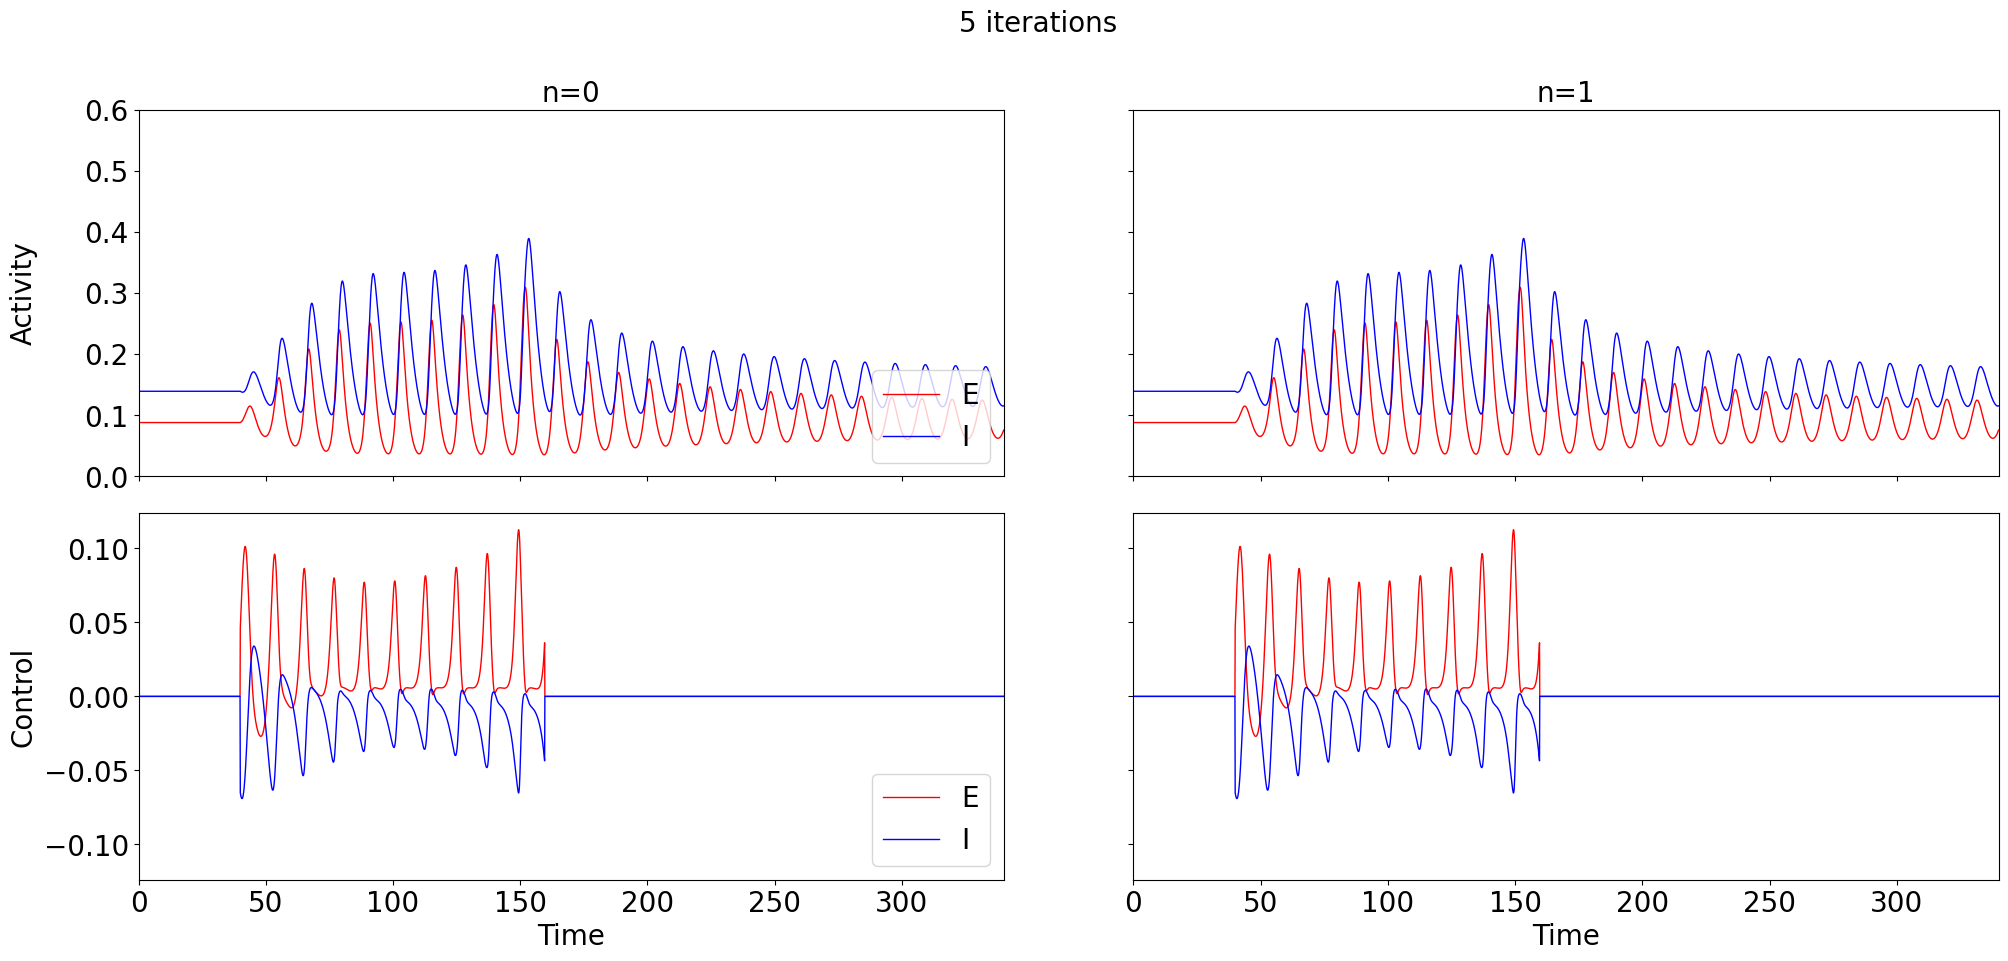

Compute control for a deterministic system
Cost in iteration 0: -0.0021886415219285445
Final cost : -0.0022813906853091787
Compute control for a deterministic system
Cost in iteration 0: -0.0022813906853091787
Final cost : -0.00228180696286559


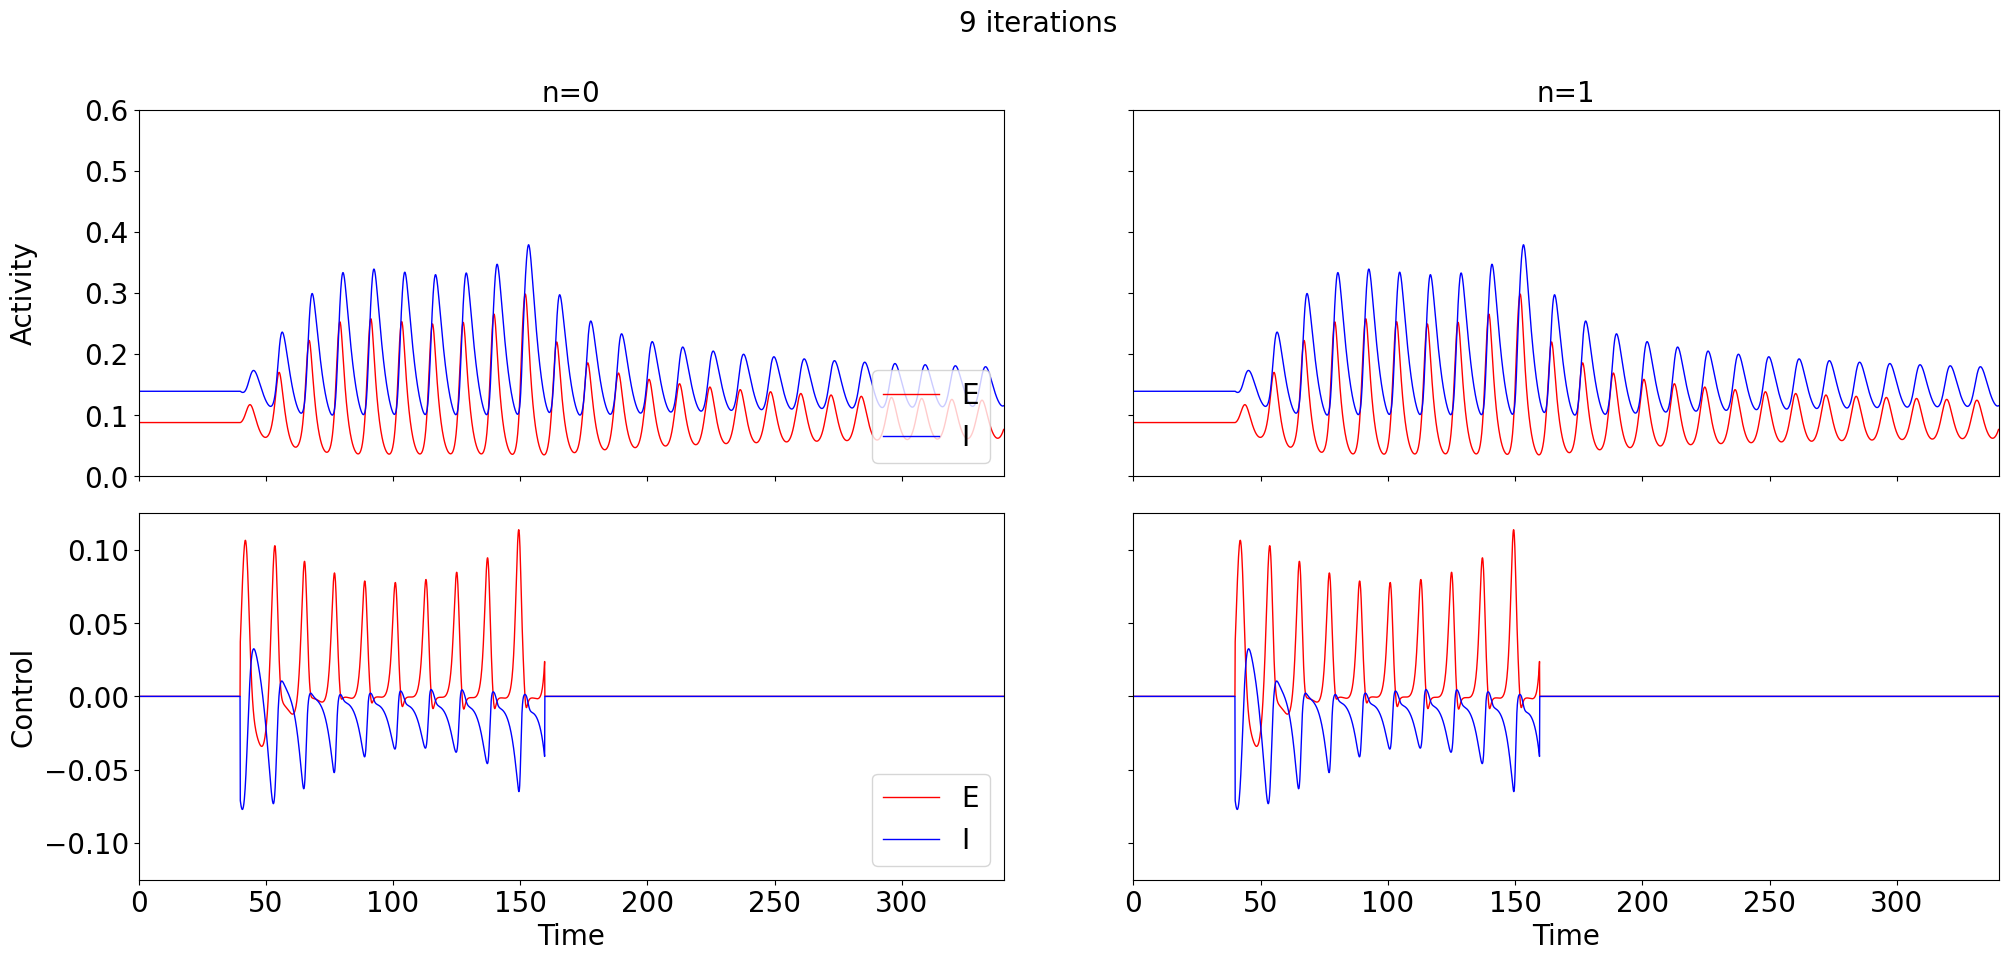

Compute control for a deterministic system
Cost in iteration 0: -0.00228180696286559
Final cost : -0.002290174644336622
Compute control for a deterministic system
Cost in iteration 0: -0.002290174644336622
Final cost : -0.00229021084001144


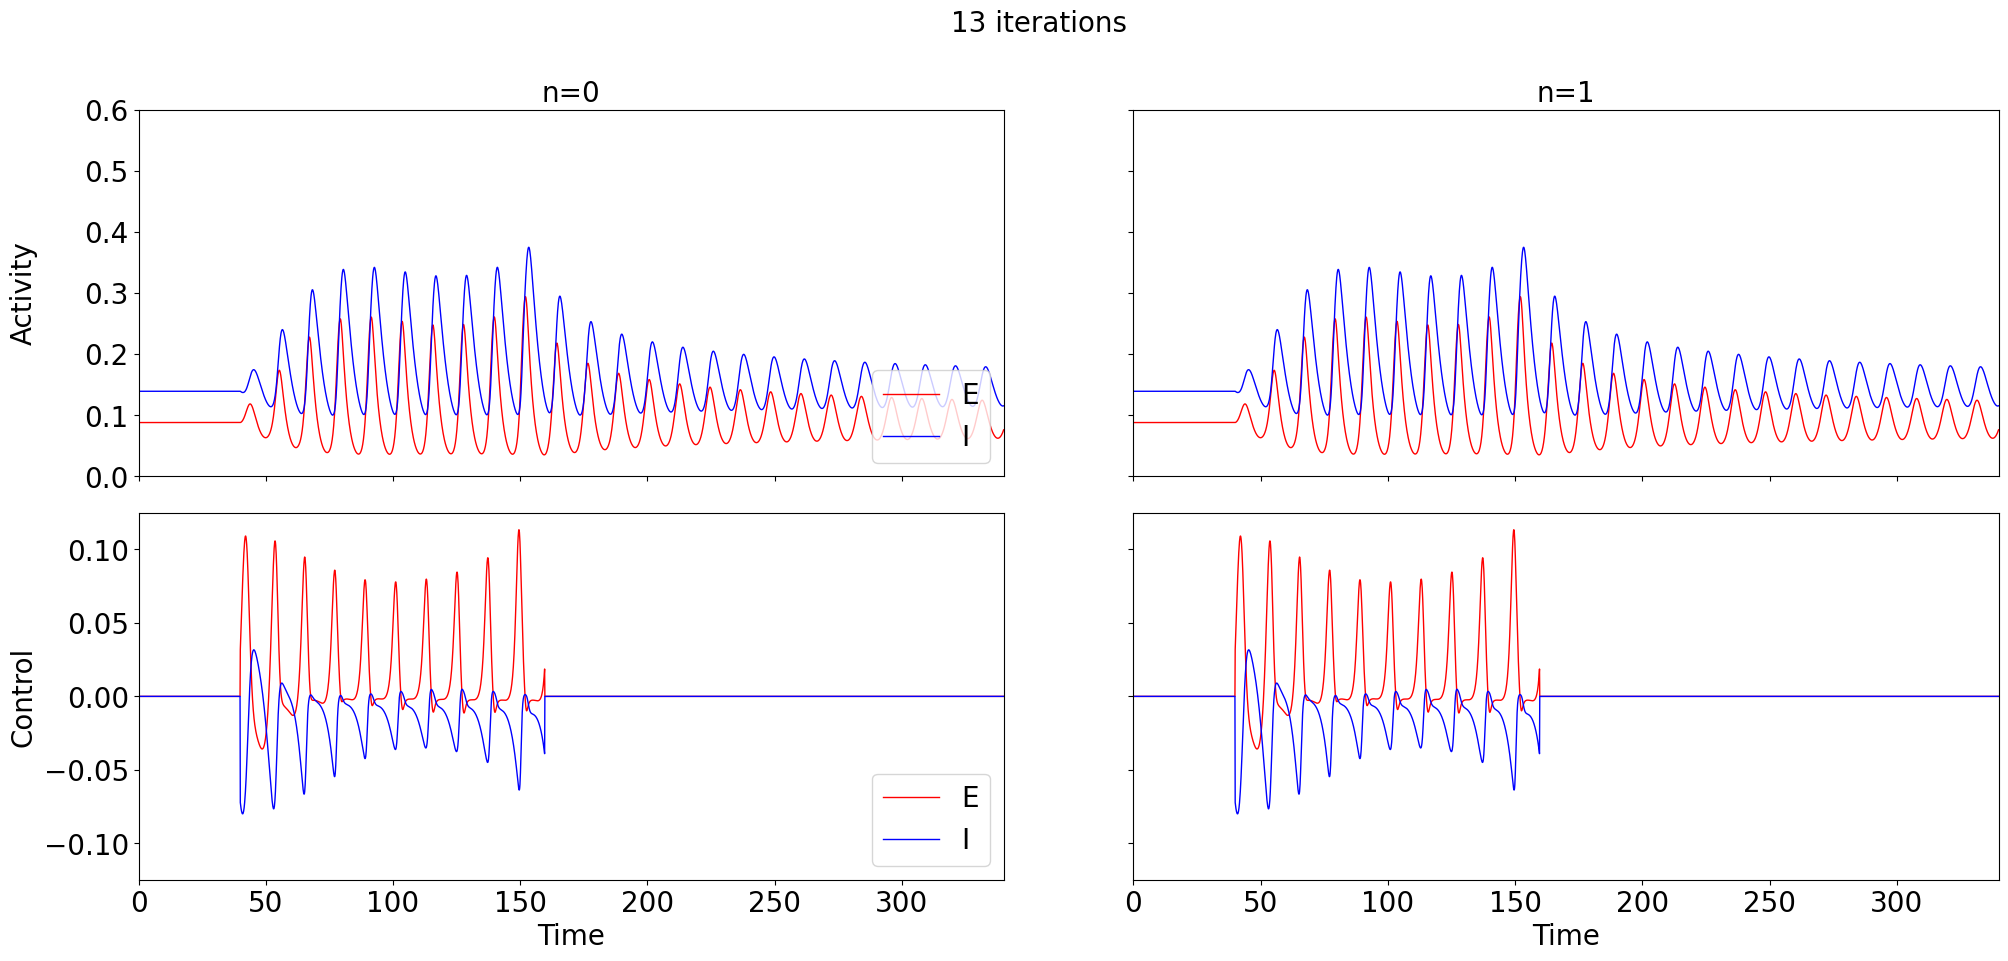

Compute control for a deterministic system
Cost in iteration 0: -0.00229021084001144
Final cost : -0.00229200677500771
w2 =  0.0005


In [78]:
it = 100

for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi" in p:
        continue

    if pi not in [1]: continue

    print("Point ", p)
      
    target_period = data[p]["target_period"]

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    nmaxdelay = model.getMaxDelay()
    print("target period, max delay = ", target_period, nmaxdelay)

    model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
    model.params.K_gl = coupling
        
    model.params.duration = data[p]["dur/per"][0]
    print("duration = ", model.params.duration)

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data[p]["init_state"][0]
    model.params["inh_init"] = data[p]["init_state"][1]

    model.run()
    
    int0 = 400
    int1 = int0 + int(data[p]["dur/per"][1]*target_period/dt)

    for wi, w2 in enumerate(data[p]["weight"]):

        print("w2 = ",w2)

        if wi not in [0]: continue

        for factor in [1]:
        #for factor in np.random.rand(10):

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, int1), 
                                          cost_matrix=costmat, control_matrix=controlmat, )
            model_controlled.channelwise_optimization = True
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2 * 100
            model_controlled.weights["w_f_sync"] = 1.

            model_controlled.maximum_control_strength = maxstr

            if False:
                if type(data[p]["control"][wi]) != type(None):
                    model_controlled.control = data[p]["control"][wi].copy()
                    model_controlled.update_input()

            input_control = zero_control.copy()
            input_control[:,0,int0:int1] = 0.05
            model_controlled.control = input_control
            model_controlled.update_input()

            model_controlled.grad_method = 0
            model_controlled.channelwise_optimization = True
            
            model_controlled.optimize(0)
            plot_control1(model_controlled.control, model_controlled.get_xs(), data[p]["dur/per"][0], dt, filename=os.path.join(dir, "static_init_0.png"), title="0 iterations")

            for k in range(4):
                model_controlled.optimize(1)
                plot_control1(model_controlled.control, model_controlled.get_xs(), data[p]["dur/per"][0], dt, filename=os.path.join(dir, "static_init_"+str(k+1)+".png"), title=str( (k+1)*4-3) + " iterations")
                model_controlled.optimize(3)

            for l in range(0):
                for k in np.arange(-10., 10., 2.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(it)

            model_controlled.grad_method = 1

            for l in range(0):
                for k in np.arange(-8., 8., 2.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(10)

            #data[p]["control"][wi] = model_controlled.control.copy()
            #data[p]["state"][wi] = model_controlled.get_xs()

    #plot_control(data[p], data[p]["dur/per"][0], dt, 0)
    #plot_control(data[p], data[p]["dur/per"][0], dt, 1)

#with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'wb') as f:
#    pickle.dump(data, f)

Point  D-osc
0.001


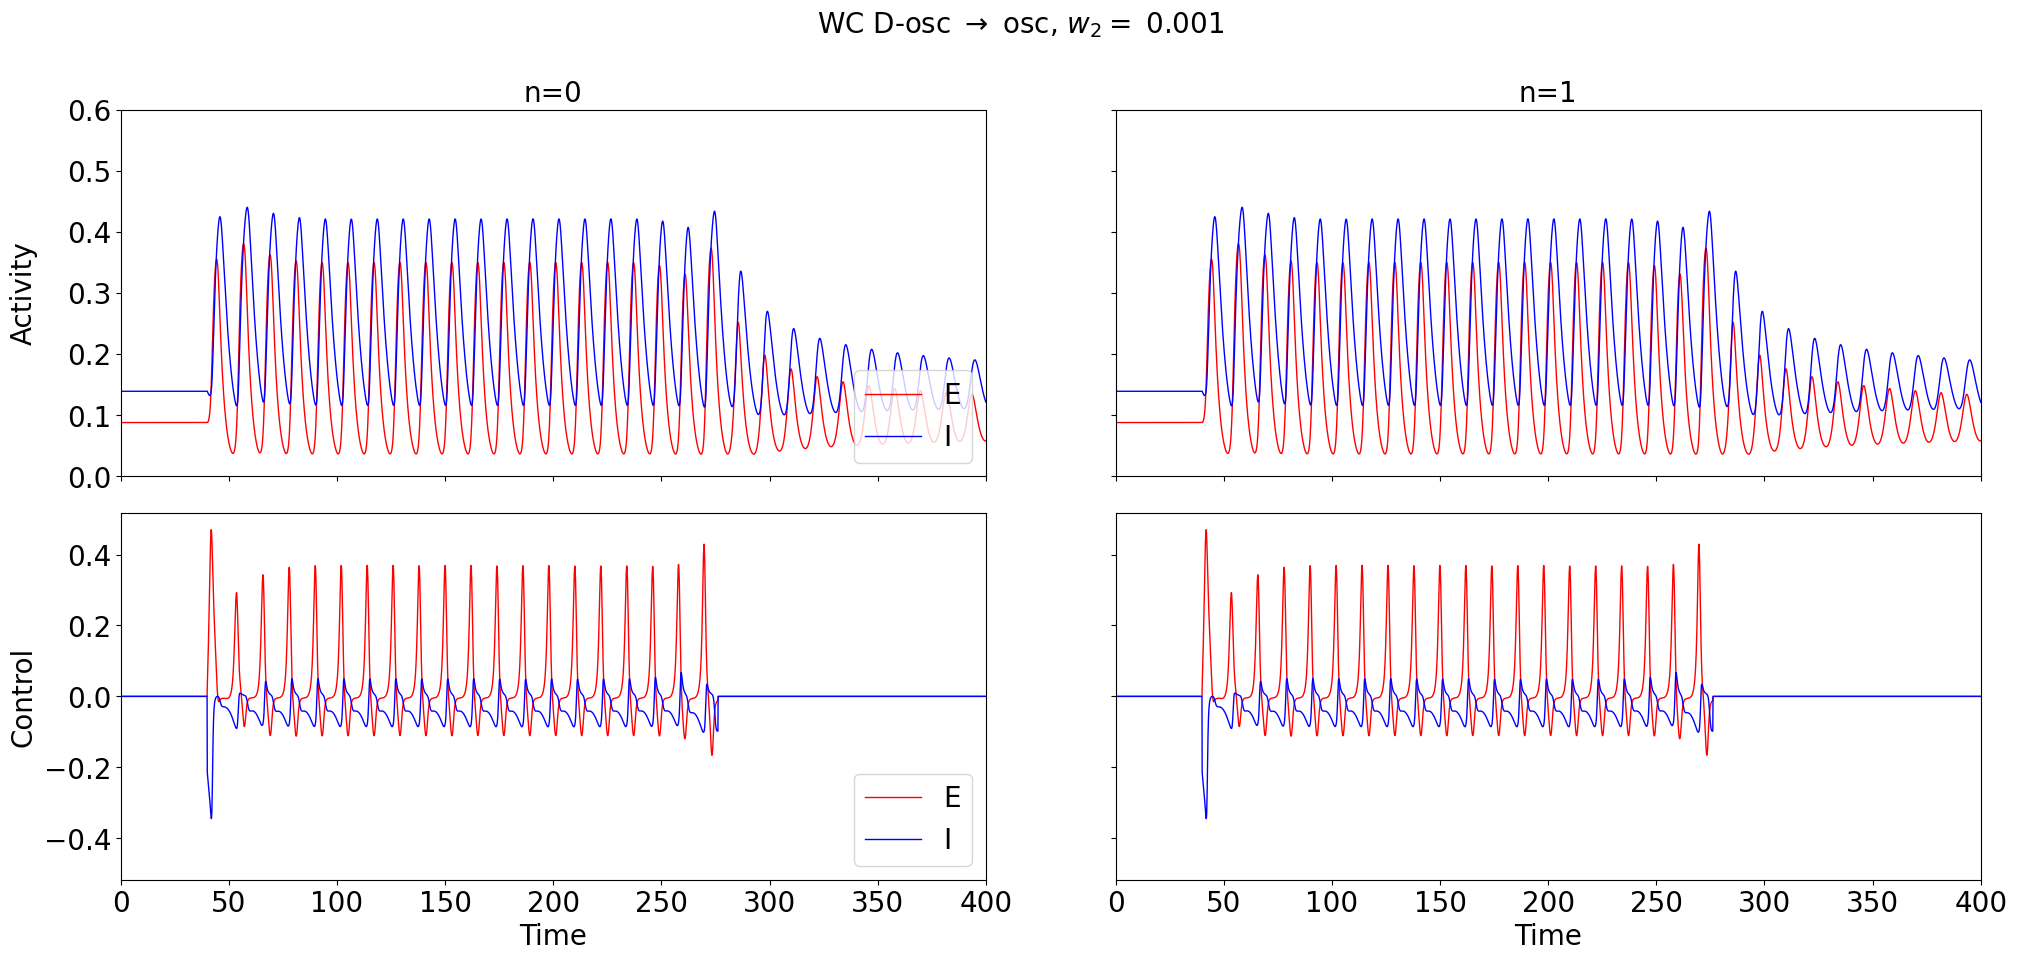

0.01


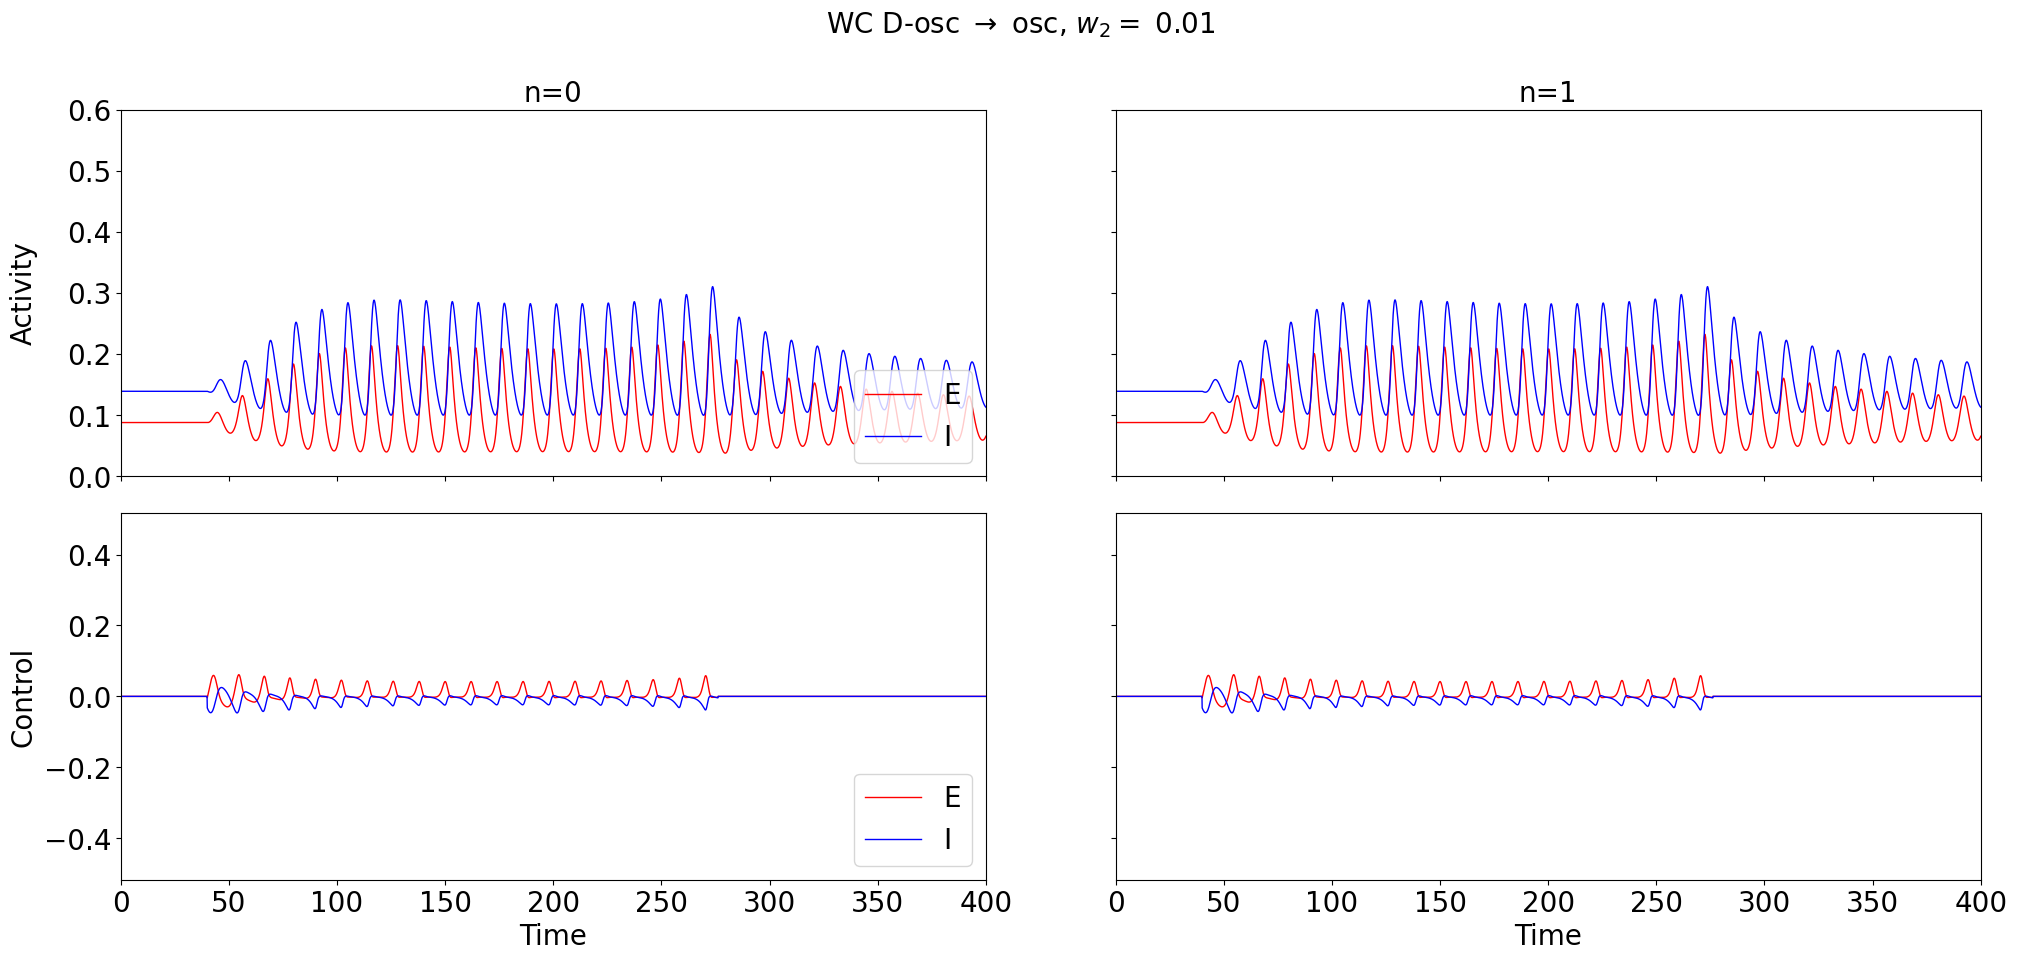

In [10]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if pi not in [1]:
        continue

    print("Point ", p)   

    for wi in range(len(data[p]["weight"])):

        print(data[p]["weight"][wi])

        filename = os.path.join(dir, str(p) + "_" + str(wi) + ".png")
        title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][wi])
        plot_control(data[p],  data[p]["dur/per"][0], dt, wi, filename=filename, title=title)

In [143]:
period_range = np.arange(11., 16., 0.3)
pr = period_range.copy()

period_range = np.zeros(( len(pr) + 2 ))
for i in range(len(pr)):
    period_range[i] = pr[i]

period_range[-2] = 18
period_range[-1] = 20

c0.append(None)
c0.append(None)
s0.append(None)
s0.append(None)

c1.append(None)
c1.append(None)
s1.append(None)
s1.append(None)

c2.append(None)
c2.append(None)
s2.append(None)
s2.append(None)

In [137]:
from numba.typed import Dict
from numba.core import types

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

period_range = np.arange(11., 16., 0.3)
period_range = np.arange(11., 16., 0.3)
pr_ = period_range.copy()

period_range = np.zeros(( len(pr_) + 2 ))
for i in range(len(pr_)):
    period_range[i] = pr_[i]

period_range[-2] = 18
period_range[-1] = 20

print(len(period_range))

c0 = [None] * len(period_range)
s0 = [None] * len(period_range)

c1 = [None] * len(period_range)
s1 = [None] * len(period_range)

c2 = [None] * len(period_range)
s2 = [None] * len(period_range)

17


In [147]:
for fi, target_period in enumerate(period_range):

    #if fi not in [0]: continue

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    model.params["exc_ext_baseline"] =  data["D-osc"]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data["D-osc"]["coordinates"][1]
    model.params.K_gl = coupling

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data["D-osc"]["init_state"][0]
    model.params["inh_init"] = data["D-osc"]["init_state"][1]

    model.run()
    
    int0 = 200
    int1 = int0 + int(data["D-osc"]["dur/per"][1]*target_period/dt)
    model.params.duration = int1 * dt + 10

    w2 = 0.2 * 1e-3

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), 
                                    cost_matrix=costmat, control_matrix=controlmat, )
    model_controlled.channelwise_optimization = True
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2
    model_controlled.weights["w_f_sync"] = 1.

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(c0[fi]) != type(None):
            model_controlled.control = c0[fi].copy()
            model_controlled.update_input()

    model_controlled.grad_method = 0
    model_controlled.channelwise_optimization = True

    for l in range(1):
        for k in np.arange(0., 10., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(it)

    for j in range(1):
        for l in range(1):
            for k in np.arange(-10., 10., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-8., 8., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    c0[fi] = model_controlled.control.copy()
    s0[fi] = model_controlled.get_xs()

    print("------------------------------ period, energy input = ", target_period, cost_functions.control_strength_cost(c0[fi], weights, dt))
    #plot_control1(c0[fi], s0[fi], model_controlled.model.params.duration, dt)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.03557899451981395
Converged in iteration 13 with cost -0.03557923737222074
Final cost : -0.03557923737222074
Compute control for a deterministic system
Cost in iteration 0: -0.03557923737222074
Converged in iteration 4 with cost -0.035579238717470256
Final cost : -0.035579238717470256
Compute control for a deterministic system
Cost in iteration 0: -0.035579238717470256
Converged in iteration 2 with cost -0.035579238717470256
Final cost : -0.035579238717470256
Compute control for a deterministic system
Cost in iteration 0: -0.035579238717470256
Converged in iteration 2 with cost -0.035579238717470256
Final cost : -0.035579238717470256
Compute control for a deterministic system
Cost in iteration 0: -0.035579238717470256
Converged in iteration 2 with cost -0.035579238717470256
Final cost : -0.035579238717470256
Compute control for a deterministic system
Cost in iteration 0: -0

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.030968331140526387
Converged in iteration 14 with cost -0.030968335747669152
Final cost : -0.030968335747669152
Compute control for a deterministic system
Cost in iteration 0: -0.030968335747669152
Converged in iteration 2 with cost -0.030968335747669152
Final cost : -0.030968335747669152
Compute control for a deterministic system
Cost in iteration 0: -0.030968335747669152
Converged in iteration 2 with cost -0.030968335747669152
Final cost : -0.030968335747669152
Compute control for a deterministic system
Cost in iteration 0: -0.030968335747669152
Converged in iteration 2 with cost -0.030968335747669152
Final cost : -0.030968335747669152
Compute control for a deterministic system
Cost in iteration 0: -0.030968335747669152
Converged in iteration 2 with cost -0.030968335747669152
Final cost : -0.030968335747669152
Compute control for a deterministic system
Cost in iteration 0

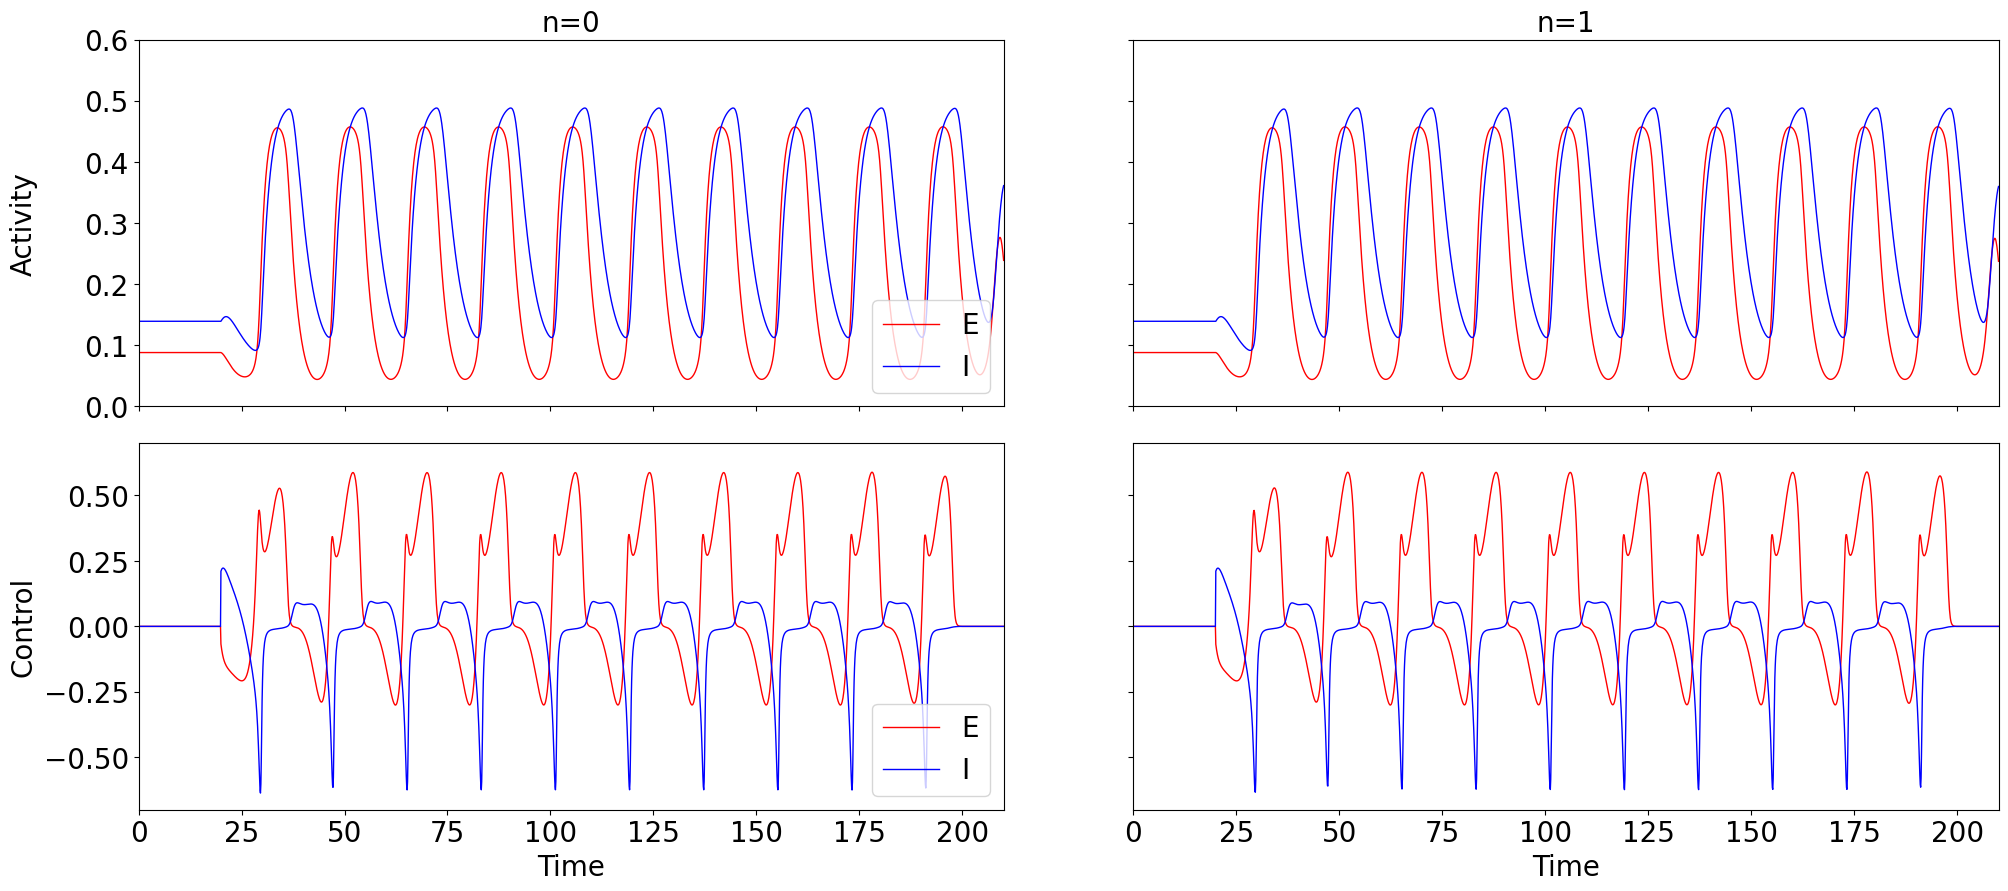

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.02296577843990081
Cost in iteration 20: -0.022967844191116006
Cost in iteration 40: -0.02296908568095779
Final cost : -0.022969571408707107
Compute control for a deterministic system
Cost in iteration 0: -0.022969571408707107
Cost in iteration 20: -0.022970538256517996
Cost in iteration 40: -0.02297162955118234
Final cost : -0.022971973363090783
Compute control for a deterministic system
Cost in iteration 0: -0.022971973363090783
Cost in iteration 20: -0.022972775605163705
Cost in iteration 40: -0.022973911641816572
Final cost : -0.02297445513363911
Compute control for a deterministic system
Cost in iteration 0: -0.02297445513363911
Cost in iteration 20: -0.022975896383505053
Cost in iteration 40: -0.02297635084070207
Final cost : -0.02297649424017752
Compute control for a deterministic system
Cost in iteration 0: -0.02297649424017752
Cost in iteration 20: -0.02297678094908

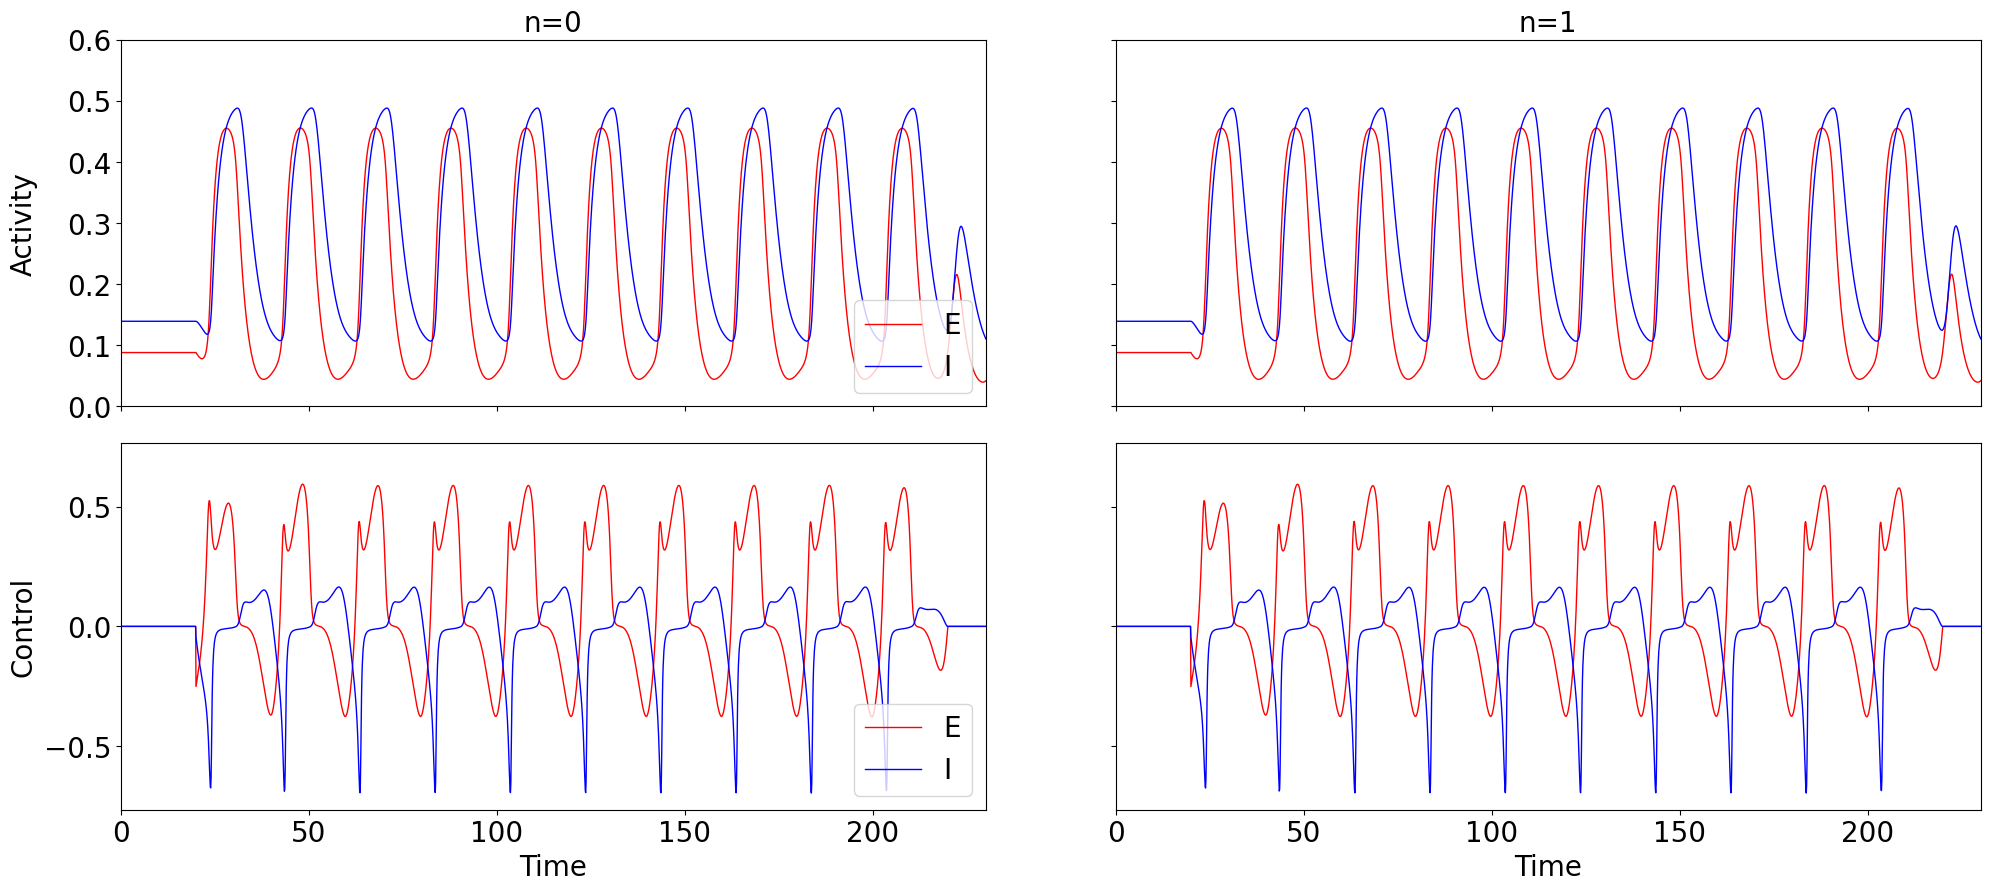

In [161]:
for fi, target_period in enumerate(period_range):

    if fi not in [17,18]: continue

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    model.params["exc_ext_baseline"] =  data["D-osc"]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data["D-osc"]["coordinates"][1]
    model.params.K_gl = coupling

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data["D-osc"]["init_state"][0]
    model.params["inh_init"] = data["D-osc"]["init_state"][1]

    model.run()
    
    int0 = 200
    int1 = int0 + int(data["D-osc"]["dur/per"][1]*target_period/dt)
    model.params.duration = int1 * dt + 10

    w2 = 1e-3

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), 
                                    cost_matrix=costmat, control_matrix=controlmat, )
    model_controlled.channelwise_optimization = True
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2
    model_controlled.weights["w_f_sync"] = 1.

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(c1[fi]) != type(None):
            model_controlled.control = c1[fi].copy()
            model_controlled.update_input()

    model_controlled.grad_method = 0
    model_controlled.channelwise_optimization = True

    for l in range(1):
        for k in np.arange(0., 10., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(it)

    for j in range(1):
        for l in range(1):
            for k in np.arange(-10., 10., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-8., 8., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    c1[fi] = model_controlled.control.copy()
    s1[fi] = model_controlled.get_xs()

    print("------------------------------ period, energy input = ", target_period, cost_functions.control_strength_cost(c1[fi], weights, dt))
    #plot_control1(c1[fi], s1[fi], model_controlled.model.params.duration, dt)

In [150]:
for fi, target_period in enumerate(period_range):

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    model.params["exc_ext_baseline"] =  data["D-osc"]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data["D-osc"]["coordinates"][1]
    model.params.K_gl = coupling

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data["D-osc"]["init_state"][0]
    model.params["inh_init"] = data["D-osc"]["init_state"][1]

    model.run()
    
    int0 = 200
    int1 = int0 + int(data["D-osc"]["dur/per"][1]*target_period/dt)
    model.params.duration = int1 * dt + 10

    w2 = 0.2 * 0.2 * 1e-3

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), 
                                    cost_matrix=costmat, control_matrix=controlmat, )
    model_controlled.channelwise_optimization = True
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2
    model_controlled.weights["w_f_sync"] = 1.

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(c2[fi]) != type(None):
            model_controlled.control = c2[fi].copy()
            model_controlled.update_input()

    model_controlled.grad_method = 0
    model_controlled.channelwise_optimization = True

    for l in range(1):
        for k in np.arange(0., 10., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(it)

    for j in range(1):
        for l in range(1):
            for k in np.arange(-10., 10., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-8., 8., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    c2[fi] = model_controlled.control.copy()
    s2[fi] = model_controlled.get_xs()

    print("------------------------------ period, energy input = ", target_period, cost_functions.control_strength_cost(c2[fi], weights, dt))
    #plot_control1(c2[fi], s2[fi], model_controlled.model.params.duration, dt)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04400081164274289
Converged in iteration 14 with cost -0.04400082219182886
Final cost : -0.04400082219182886
Compute control for a deterministic system
Cost in iteration 0: -0.04400082219182886
Converged in iteration 6 with cost -0.044000823558589565
Final cost : -0.044000823558589565
Compute control for a deterministic system
Cost in iteration 0: -0.044000823558589565
Converged in iteration 2 with cost -0.044000823558589565
Final cost : -0.044000823558589565
Compute control for a deterministic system
Cost in iteration 0: -0.044000823558589565
Converged in iteration 2 with cost -0.044000823558589565
Final cost : -0.044000823558589565
Compute control for a deterministic system
Cost in iteration 0: -0.044000823558589565
Converged in iteration 2 with cost -0.044000823558589565
Final cost : -0.044000823558589565
Compute control for a deterministic system
Cost in iteration 0: -0

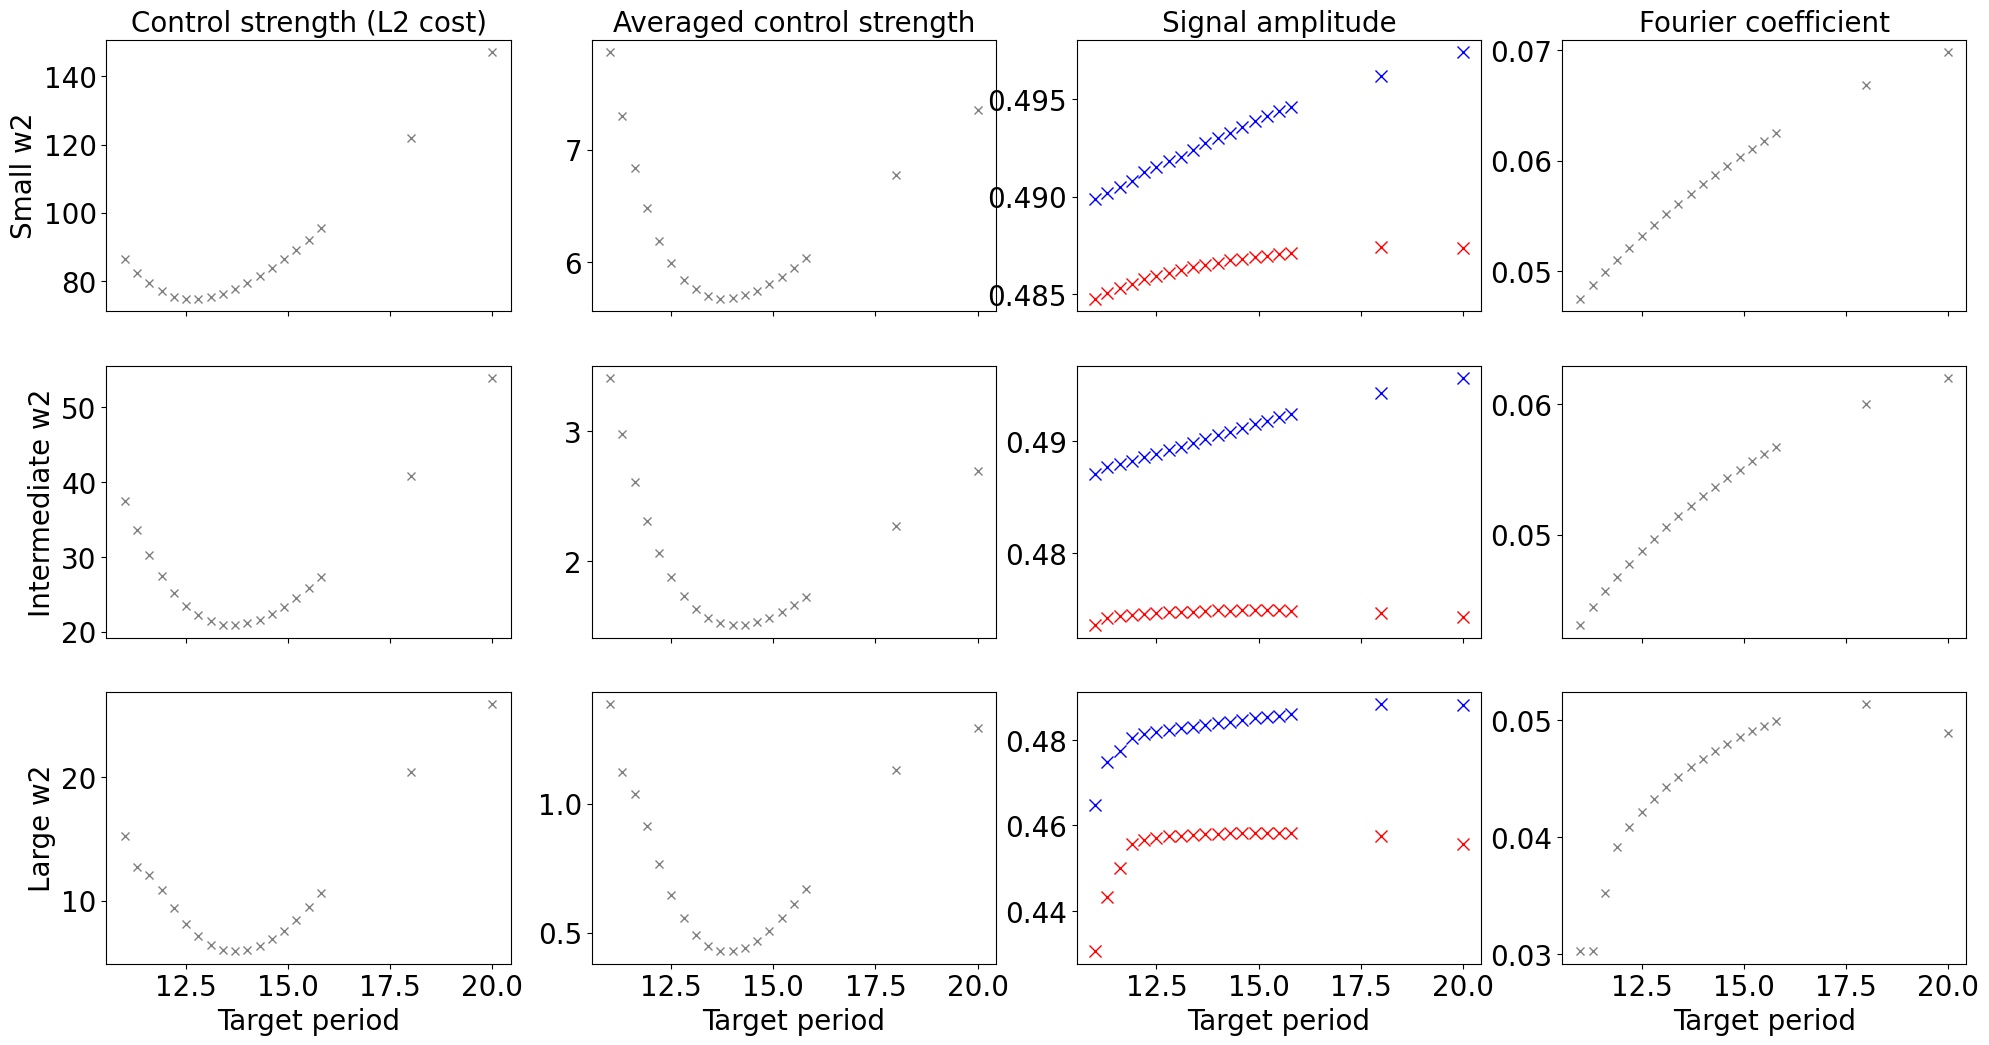

In [162]:
fig, ax = plt.subplots(3,4, figsize=(24,12), sharex=True)

for fi, target_period in enumerate(period_range):

    int0 = 200
    int1 = int0 + int(data["D-osc"]["dur/per"][1]*target_period/dt)

    col = "gray"
    ms = 8
    

    control_strength = cost_functions.control_strength_cost(c2[fi], weights, dt)
    av_control_strength = control_strength / target_period
    osc_amp = [np.amax(s2[fi][:,0,:]), np.amax(s2[fi][:,1,:])]
    fourier_cost = - sum(cost_functions.fourier_cost_sync(s2[fi], dt, target_period, costmat, [int0,int1]))

    ax[0,0].plot(target_period, control_strength, marker="x",color=col)
    ax[0,1].plot(target_period, av_control_strength, marker="x",color=col)
    ax[0,2].plot(target_period, osc_amp[0], marker="x",color="red", markersize=ms)
    ax[0,2].plot(target_period, osc_amp[1], marker="x",color="blue", markersize=ms)
    ax[0,3].plot(target_period, fourier_cost, marker="x",color=col)

    control_strength = cost_functions.control_strength_cost(c0[fi], weights, dt)
    av_control_strength = control_strength / target_period
    osc_amp = [np.amax(s0[fi][:,0,:]), np.amax(s0[fi][:,1,:])]
    fourier_cost = - sum(cost_functions.fourier_cost_sync(s0[fi], dt, target_period, costmat, [int0,int1]))

    ax[1,0].plot(target_period, control_strength, marker="x",color=col)
    ax[1,1].plot(target_period, av_control_strength, marker="x",color=col)
    ax[1,2].plot(target_period, osc_amp[0], marker="x",color="red", markersize=ms)
    ax[1,2].plot(target_period, osc_amp[1], marker="x",color="blue", markersize=ms)
    ax[1,3].plot(target_period, fourier_cost, marker="x",color=col)

    control_strength = cost_functions.control_strength_cost(c1[fi], weights, dt)
    av_control_strength = control_strength / target_period
    osc_amp = [np.amax(s1[fi][:,0,:]), np.amax(s1[fi][:,1,:])]
    fourier_cost = - sum(cost_functions.fourier_cost_sync(s1[fi], dt, target_period, costmat, [int0,int1]))

    ax[2,0].plot(target_period, control_strength, marker="x",color=col)
    ax[2,1].plot(target_period, av_control_strength, marker="x",color=col)
    ax[2,2].plot(target_period, osc_amp[0], marker="x",color="red", markersize=ms)
    ax[2,2].plot(target_period, osc_amp[1], marker="x",color="blue", markersize=ms)
    ax[2,3].plot(target_period, fourier_cost, marker="x",color=col)

ax[0,0].set_title("Control strength (L2 cost)")
ax[0,1].set_title("Averaged control strength")
ax[0,2].set_title("Signal amplitude")
ax[0,3].set_title("Fourier coefficient")

ax[0,0].set_ylabel("Small w2")
ax[1,0].set_ylabel("Intermediate w2")
ax[2,0].set_ylabel("Large w2")

ax[-1,0].set_xlabel("Target period")
ax[-1,1].set_xlabel("Target period")
ax[-1,2].set_xlabel("Target period")
ax[-1,3].set_xlabel("Target period")

plt.show()
fig.tight_layout()

fig.savefig(os.path.join(dir, "freq_range.png"))

In [ ]:
with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [4]:
with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['D-exp', 'D-osc', 'U-exp', 'U-osc', 'Bi-exp', 'Bi-osc'])
